In [1]:
import torch
print(f'PyTorch Version: {torch.__version__}.')

import numpy as np
from matplotlib import pyplot as plt

from graphviz import Digraph # pip install graphviz

torch.manual_seed(1337)
np.random.seed(1337)

PyTorch Version: 2.0.1.


In [66]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # no effect
        self.label = label

        self._backward = lambda: None # "_backward" stores/caches a function.
        self._prev = set(_children)
        self._op = _op
    #end-def

    def __repr__(self) -> str:
        return f'Value(data={self.data}, grad={self.grad}, label={self.label})'
    #end-def

    def __add__(self, other: object):

        other = other if isinstance(other, Value) else Value(other)

        output = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad  += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            # print('inside: __add__')
        #end-def
        output._backward = backward
        '''
        Let's consider,
        (a) "backward()" is function and "_backward" is a variable [class: Value, object: output].
        (b) If we would like to cache the function, we could write "output._backward = backward" as expression.
        (c) However, we could not write "output._backward = backward()" as expression
            because it will automatically call everytime.
        (d) It is a technique to store/cache a function so that we could use when it is required.
        '''

        return output
    #end-def

    def __radd__(self, other: object):
        return self + other
    #end-def

    def __mul__(self, other: object):

        other = other if isinstance(other, Value) else Value(other)

        output = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad  += other.data * output.grad
            other.grad += self.data * output.grad
            # print('inside: __mul__')
        #end-def
        output._backward = backward

        return output
    #end-def

    def __rmul__(self, other: object): # other * self
        return self * other
    #end-def

    def __sub__(self, other): # self - other
        return self + (-other)
    #end-def

    def __rsub__(self, other): # other - self
        return other + (-self)
    #end-def

    def __neg__(self):
        return self * -1.0
    #end-def

    def __truediv__(self, other): #self/other
        return self * (other ** -1)
    #end-def

    def __rtruediv__(self, other): # other/self
        return other * (self ** -1)
    #end-def

    def __pow__(self, other: object):
        '''
        # function call: a.pow(3)
        self  ← a # "self"  represents "a" object of class:Value.
        other ← 3 # "other" represents "3"
        '''

        # __o = __o if isinstance(__o, Value) else Value(__o)

        assert isinstance(other, (int, float)), f'The tool accepts "integer" and "float" as exponent value.'

        output = Value(self.data ** other, (self,), f'pow ({self.data}^{other})')

        def backward():
            self.grad += (other * (self.data ** (other - 1.0))) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def exp(self):
        o = np.exp(self.data)

        output = Value(np.exp(self.data), (self,), 'exp')

        def backward():
            self.grad += o * output.grad # output.data * output.grad --> local derivative x chain rule.
        #end-def
        output._backward = backward

        return output
    #end-def

    # Activation Functions — non-linear functions:
    def tanh(self):
        x = self.data

        # o = (np.exp(2.0 * x) - 1.0) / (np.exp(2.0 * x) + 1.0)
        o = np.tanh(x)

        output = Value(o, (self,), 'tanh')

        def backward():
            self.grad += (1.0-(output.data**2.0)) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def sigmoid(self):
        x = self.data

        o = 1.0 / (1.0 + np.exp(-x))
        # o = np.tanh(x)

        output = Value(o, (self,), 'sigmoid')

        def backward():
            self.grad += o * (1.0-o) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    # def softmax(self):
    #     pass
    # #end-def

    def log(self):
        x = self.data
        output = Value(np.log(x), (self,), 'log')

        def backward():
            self.grad += (1.0 / x) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def


    def relu(self,):
        x = self.data

        output = Value(x if x>0.0 else 0.0, (self,), 'ReLU')

        def backward():
            self.grad += (1.0 if x>0.0 else 0.0) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def maximum(self, other: object):
        x = self.data
        y = other.data

        print(f'self: {self.data}, other: {other.data}')

        output = Value(max(x, y), (self, other), f'max({self.data}, {other.data})')

        def backward():
            '''
            Reference: https://cs231n.github.io/optimization-2/
            '''
            self.grad  += (1.0 if x>=y else 0.0) * output.grad
            other.grad += (1.0 if y>=x else 0.0) * output.grad
        #end-def
        output._backward = backward
        return output

        # def backward():
        #     if x>=y:_
        #         self.grad  += 1.0 * output.grad
        #         other.grad += 0.0 * output.grad
        #     else:
        #         self.grad  += 0.0 * output.grad
        #         other.grad += 1.0 * output.grad
        # #end-def
        # output._backward = backward
        # return output
    #end-def

    def minimum(self, other: object):
        x = self.data
        y = other.data

        print(f'self: {self.data}, other: {other.data}')

        output = Value(min(x, y), (self, other), f'min({self.data}, {other.data})')

        def backward():
            '''
            Reference: https://cs231n.github.io/optimization-2/
            '''
            self.grad  += (1.0 if y>=x else 0.0) * output.grad
            other.grad += (1.0 if x>=y else 0.0) * output.grad
        #end-def
        output._backward = backward
        return output
    #end-def

    def reciprocal(self):
        x = self.data
        output = Value(1.0/x, (self,), 'reciprocal (i.e., 1/x)')
        def backward():
            self.grad = -(1/(x**2.0)) * output.grad
        #end-def
        output._backward = backward
        return output
    #end-def

    #Differential Calculus:
    def backward(self):
        '''
        self = o
        "self" indecates "o"
        '''

        topo = []
        visited = set()

        def build_topology(v):
            # print('works!')
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                #end-for
                topo.append(v)
            #end-if/else
        #end-def
        build_topology(self)
        # print(topo)

        self.grad = 1.0     # ∂(o)/∂o = 1
        for node in reversed(topo):
            # print(node._backward())
            node._backward()
        #end-for
    #end-def
#end-class

In [67]:
'''
@program: Topological Sort
@author : Andrej Karpathy
@date   : God knows.
'''

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
            #end-for
        #end-if/else
    #end-def
    build(root)
    return nodes, edges
#end-def


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        # dot.node(f'name {uid}, label = {n.label} | data = {n.data:.4f} | grad = {n.grad:.4f}', shape='record')
        dot.node(name = uid, label = "{%s | data = %.4f | grad = %.8f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        #end-else/if
    #end-for

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    #end-for

    return dot
#end-def

### Exercise:

In [9]:
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]

print(logits)

# print(max(outputs))
# print(sum(outputs.data))

counts = [logit.exp() for logit in logits]
print(counts)

print(sum(counts))
# print(max(counts))

# denominator = sum(counts)
# print(denominator)

[Value(data=0.0, grad=0.0, label=), Value(data=3.0, grad=0.0, label=), Value(data=-2.0, grad=0.0, label=), Value(data=1.0, grad=0.0, label=)]
[Value(data=1.0, grad=0.0, label=), Value(data=20.085536923187668, grad=0.0, label=), Value(data=0.1353352832366127, grad=0.0, label=), Value(data=2.718281828459045, grad=0.0, label=)]
Value(data=23.939154034883327, grad=0.0, label=)


In [45]:
# https://en.wikipedia.org/wiki/Softmax_function

def softmax(logits):
    counts = [logit.exp() for logit in logits]
    summation = sum(counts)
    return [count/summation for count in counts]
#end-for
    # return counts
    # # print(counts)
    # denominator = sum(counts)
    # print(denominator)
    # # print('---')
    # out = [c / denominator for c in counts]
    # return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
# # print(probs)
print(probs)
loss = -probs[3].log() # dim 3 acts as the label for this input example
print(loss)
loss.backward()
# print(loss.data)

[Value(data=0.04177257051535045, grad=0.0, label=), Value(data=0.839024507462532, grad=0.0, label=), Value(data=0.00565330266221633, grad=0.0, label=), Value(data=0.11354961935990122, grad=0.0, label=)]
Value(data=2.1755153626167147, grad=0.0, label=)


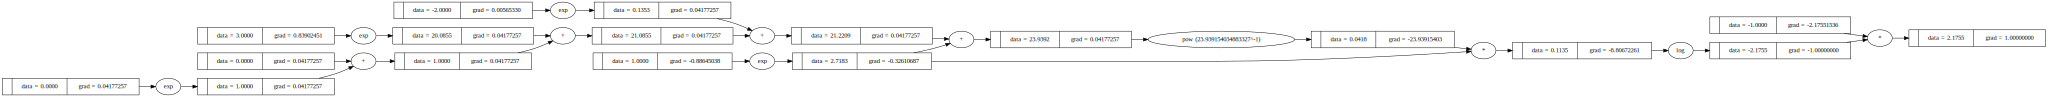

In [48]:
draw_dot(loss)

In [47]:
-np.log(0.11354)

2.175600081239557

In [42]:
# print(probs)
# print(sum(probs))

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
    ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
    print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")
#end-for

OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


In [64]:
logits = torch.tensor([[0.0, 3.0, -2.0, 1]], requires_grad=True)

probs = torch.softmax(logits, dim=1)[0]
print(probs)
loss = -probs[3].log()
print(loss)
loss.backward()
print(logits.grad)

tensor([0.0418, 0.8390, 0.0057, 0.1135], grad_fn=<SelectBackward0>)
tensor(2.1755, grad_fn=<NegBackward0>)
tensor([[ 0.0418,  0.8390,  0.0057, -0.8865]])


In [53]:
logits = torch.tensor([[0.0, 3.0, -2.0, 1.0]], requires_grad=True)
probs = torch.softmax(logits, dim=1)[0]
# print(f"probs: {probs}")
# loss = -probs[3].log()
# loss.backward()

self: 2.0, other: -1.0
Value(data=-20.0, grad=0.0, label=)


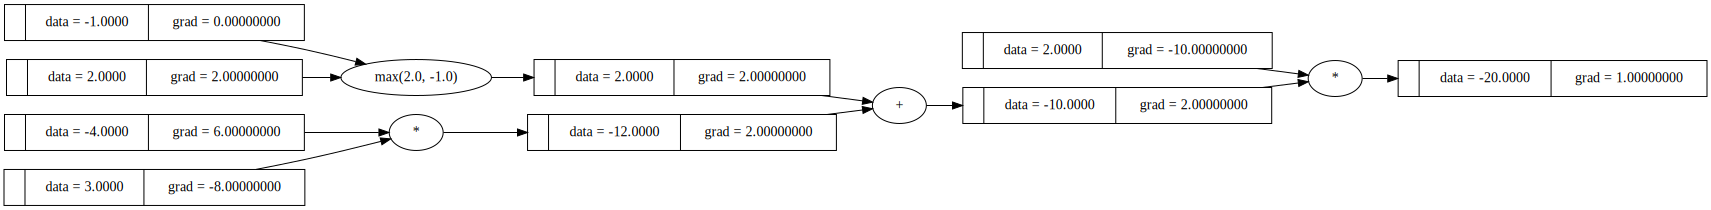

In [5]:
x = Value(+3.0)
y = Value(-4.0)
z = Value(+2.0)
w = Value(-1.0)

o = ((x*y) + z.maximum(w)) * 2.0
print(o)

o.backward()
draw_dot(o)

In [32]:
# forward pass
W = np.random.randn(5, 10)
X = np.random.randn(10, 3)
D = np.dot(W, X)

print(f'W: {W.shape}')
print(f'X: {X.shape}')
print(f'D: {D.shape}')

# now suppose we had the gradient on D from above in the circuit
dD = np.random.randn(*D.shape) # same shape as D
print(f'dD: {dD.shape}')

dW = dD.dot(X.T) #.T gives the transpose of the matrix
print(f'dW: {dW.shape}')

dX = W.T.dot(dD)
print(f'dX: {dX.shape}')

W: (5, 10)
X: (10, 3)
D: (5, 3)
dD: (5, 3)
dW: (5, 10)
dX: (10, 3)


In [34]:
X = np.array([
    [  1,   2],
    [ 10,  20],
    [100, 200],
])

W = np.array([
    [0.5, 0.25, 0.125],
    [  5,  2.5, 1.250],
    [ 25, 12.5, 6.250],
    [125, 62.5, 31.25]
])

D = np.dot(W, X)
print(D)

[[  15.5   31. ]
 [ 155.   310. ]
 [ 775.  1550. ]
 [3875.  7750. ]]


In [14]:
# a = Value(1.37)
# o = 1/a
# o.backward()
# draw_dot(o)

In [15]:
# import math

# w = [2,-3,-3] # assume some random weights and data
# x = [-1, -2]

# # forward pass
# dot = w[0]*x[0] + w[1]*x[1] + w[2]
# f = 1.0 / (1 + math.exp(-dot)) # sigmoid function
# print(f)

# # backward pass through the neuron (backpropagation)
# ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation

# print(ddot)

# dx = [w[0] * ddot, w[1] * ddot] # backprop into x
# print(dx)
# dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w
# # we're done! we have the gradients on the inputs to the circuit

# print(dw)

In [102]:
# a = Value(2.5)

# o = a**3

# o.backward()

# draw_dot(o)

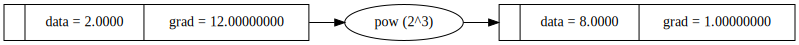

In [8]:
x = Value(2)
o = x**3

o.backward()
draw_dot(o)

self: 50, other: 101


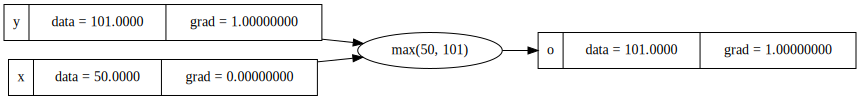

In [45]:
x = Value(50); x.label = 'x'
y = Value(101); y.label = 'y'

o = x.max(y); o.label = 'o'

o.backward()
draw_dot(o)

In [103]:
# Epochs = 5
# for i in range(Epochs):
#     o.backward()
# #end-for
# draw_dot(o)

In [68]:
class Neuron:
    def __init__(self, N: int) -> None:
        '''
        arguments:
            N (int): N indicates the number of input (#N).
        return:
            None
        '''

        V = np.random.randn(N) * np.sqrt(2.0/N)
        self.W = [Value(v) for v in V]
        self.b = Value(0.0)


        # self.W = [Value(np.random.uniform(low=-1., high=1.0)) for _ in range(N)]
        # self.b = Value(np.random.uniform(low=-1., high=1.0))


        # self.W = [Value(np.random.uniform(low=-1., high=1.0)) for _ in range(N)]
        # self.b = Value(np.random.uniform(low=-1., high=1.0))

        # self.W = [Value(3.5) for _ in range(N)]
        # self.b = Value(1.5)

    #end-def
        
    def __repr__(self,) -> str:
        return f'W:{self.W}\nb:{self.b:0.4f}'
    #end-def

    def __call__(self, X):
        # block-1: easier to understand
        # output = 0.0
        # for w, x in zip(self.W, X):
        #     output += (w*x)
        # #end-for
        # output += self.b

        # output = output.relu()   

        # return output
        

        # block-2: Rafsanjani
        output = sum((w*x) for w, x in zip(self.W, X))
        output += self.b
        
        output = output.relu()
        # output = output.tanh()
        return output

        # block-3: Rafsanjani
        # output = sum((w*x) for w, x in zip(self.W, X)) + self.b
        # output = output.relu()
        # return output
        
        # block-4: Dr. Karpathy uses it.
        # output = sum(((w*x) for w, x in zip(self.W, X)), self.b)
        # output = output.relu()
        # return output
    #end-def
    
    def parameters(self):
	    return self.W + [self.b]
    #end-def
#end-def

Value(data=0.10311722873663214, grad=0.0, label=)


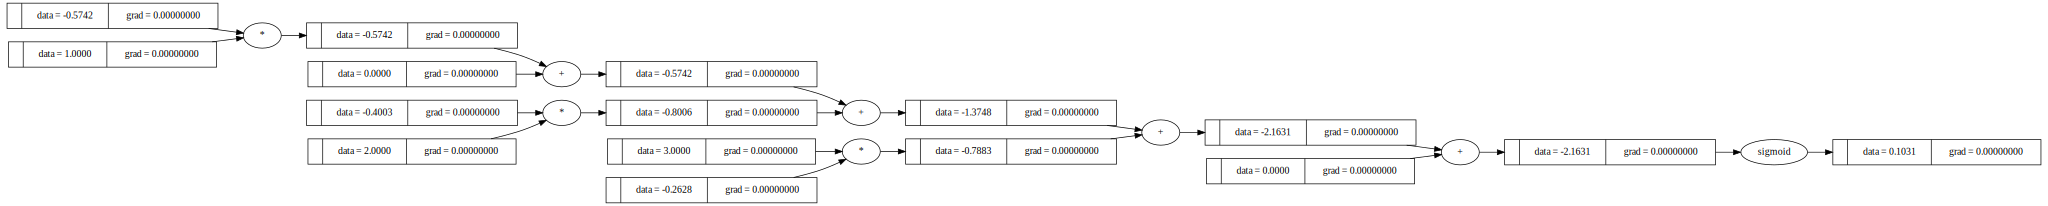

In [105]:
neuron = Neuron(3)
X =[1, 2, 3]
output = neuron(X)
print(output)

draw_dot(output)

# Neuron(3)(X) # Value(data=22.5, grad=0.0, label=)

In [106]:
# n = Neuron(3)
# X = [1, 2, 3]

# o = n(X)

# o.backward()

# draw_dot(o)

In [107]:
# a = Value(10)
# o = a.tanh()

# o.backward()

# draw_dot(o)

In [108]:
# x1 = Value(2.0,  label='x1')
# w1 = Value(-3.0, label='w1')


# x2 = Value(0.0, label='x2')
# w2 = Value(1.0, label='w2')


# b  = Value(6.88, label='b') # When b = 6.88, 1-o^2 = 0.50


# x1w1 = x1*w1; x1w1.label = 'x1*w1'
# x2w2 = x2*w2; x2w2.label = 'x2*w2'


# x1w1x2w2 = x1w1 + x2w2
# x1w1x2w2.label = '(x1*w1) + (x2*w2)'


# n = x1w1x2w2 + b; n.label = 'n'
# # print(n)


# o = n.tanh(); o.label = 'o'
# # print(o)


# # show grads:
# draw_dot(o)

In [109]:
# o.backward()

# draw_dot(o)

In [110]:
# a = Value(15)
# o = a.sigmoid()
# o.backward()

# draw_dot(o)

In [111]:
# x = torch.tensor([10], dtype=float, requires_grad=True)

# # Tanh shows "Vanishing Gradient" (if x>5): gradient of a (∂o/∂x) x: 0.00018158 → 0.0
# # o = torch.tanh(x)


# # Sigmoid shows "Vanishing Gradient" (if x>5): gradient of a (∂o/∂x) x: 0.00004540 → 0.0
# # o = torch.sigmoid(x)
# # Sigmoid gets "zero" more quickly compared to Tanh.


# # However, ReLU shows "No Vanishing Gradient": gradient of a (∂o/∂x) x: 1.00000000
# o = torch.relu(x)
# # That is why, ReLU is popular.

# o.backward()

# print(f'gradient of a (∂o/∂x) x: {x.grad.item():0.8f}')

In [112]:
# Epochs = 5
# for i in range(Epochs):
#     o.backward()
# #end-for

# dot = draw_dot(o)

# dot.render('1-neuron.pdf', view=True)

In [113]:
# n = Neuron(3)

### n.W
# Output:
# [Value(data=3.5, grad=0.0, label=),
#  Value(data=3.5, grad=0.0, label=),
#  Value(data=3.5, grad=0.0, label=)]

### n.b
# Output:
# Value(data=1.5, grad=0.0, label=)

# X = [1,]
# o = n(X)
# draw_dot(o)

In [69]:
class Layer:
    def __init__(self, N_in=3, N_out=4) -> None:
        self.neurons = [Neuron(N_in) for _ in range(N_out)]
    #end-def
        
    def __repr__(self,) -> str:
        return f'Neurons: {self.neurons}'
    #end-def
    
    def __call__(self, X):
        outputs = [neuron(X) for neuron  in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
        # return outputs
    #end-def

    def parameters(self):
	    return [p for neuron in self.neurons for p in neuron.parameters()]
    
        # params = []
        # for neuron in self.neurons:
        # 	ps = neuron.parameters()
        # 	params.extend(ps)
        # #end-for
        # return params
    #end-def
#end-def

In [115]:
# X = [1, 2, 3]
# layer = Layer(N_in=3, N_out=4)
# v = []
# for neuron in layer.neurons:
#     v.append(neuron(X))
#     # break

In [116]:
# layer = Layer(3, 4)
# for neuron in layer.neurons:
#     print(neuron.W)

In [117]:
# X =[1, 2, 3]
# layer = Layer(3, 4)
# neurons = layer(X)
# # print(neurons)

# # print(neurons[0])

# # draw_dot(neurons[0])

# for neuron in neurons:
#     # print(neuron)
#     draw_dot(neuron)

In [118]:
# # l = Layer(3, 4)
# # X = [1, 2, 3]

# # l(X)

# # print(o)
# # draw_dot(o)

# # print(l)

# # layer = Layer(2, 3)
# # # this layer has 3 neurons, each neuron has 2 input
# # for neuron in layer.neurons:
# #     print (neuron.w)

# X = [1, 2, 3]
# layer = Layer(3, 4)
# v = layer(X)
# v
# # draw_dot(v)


# # for neuron in layer.neurons:
# #     print(neuron)
# # #end-for

In [119]:
# class MLP:
#     def __init__(self, N_in, N_outs) -> None:
#         sz = [N_in] + N_outs # [3] + [4, 4, 1] → [3, 4, 4, 1]
#         self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(N_outs))]
#     #end-def
    
#     def __repr__(self,) -> str:
#         pass
#     #end-def
    
#     def __call__(self, X):
#         for layer in self.layers:
#             X = layer(X)
#         #end-for
#         return X
#     #end-def
# #end-class

In [70]:
class MLP:
    def __init__(self, N_in, N_outs) -> None:
        size = [N_in] + N_outs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(N_outs))]
        # print(N_in, N_outs)
    #end-def
    
    # def __repr__(self,) -> str:
    #     pass
    # #end-def

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"
    #end-def

    def __call__(self, X):
        # print(f'{len(self.layers)}')
        # print(f'{self.layers[0]}')
        for layer in self.layers:
            X = layer(X)
            # print(f'{len(X)}')
        #end-for
        return X
    #end-def

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
        # params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # #end-for
        # return params
    #end-def
#end-class

In [71]:
# X = [
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
# ]

X = [1, 2, 3]

model = MLP(3, [4, 4, 1])
o = model(X)

# o
o.backward()
print(o)
print(o.tanh())
# draw_dot(o)

Value(data=0.0, grad=1.0, label=)
Value(data=0.0, grad=0.0, label=)


In [78]:
model = MLP(3, [4, 4, 1])

# X = [
#     [1,      2,     3],
#     [10,    20,    30],
#     [100,  200,   300],
#     [1000, 2000, 3000],
# ]

# Y = [1, -1, -1, 1]

X = [
    [2,   3,  -1],
    [3,  -1, 0.5],
    [0.5, 1,   1],
    [1,   1,  -1],
]

Y = [1, -1, -1, 1]

Yp = [model(x) for x in X]
# print(Ypred)
Yp

[Value(data=0.05540795127367144, grad=0.0, label=),
 Value(data=0.5659556090488591, grad=0.0, label=),
 Value(data=0.7831805896485003, grad=0.0, label=),
 Value(data=1.2784664959888772, grad=0.0, label=)]

In [123]:
len(model.parameters())

41

In [124]:
# draw_dot(Yp[1])

In [125]:
loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
loss

Value(data=4.707201333836983, grad=0.0, label=)

In [126]:
# dot = draw_dot(loss)
# dot.render('MLP_Network_4_inputs', view=False)

In [127]:
loss.backward()

In [128]:
# draw_dot(loss)

In [129]:
model.layers[0].neurons[0].W[0]

Value(data=-0.007141511430650257, grad=0.1143084144284877, label=)

In [130]:
model.layers[0].neurons[0].W[0].grad

0.1143084144284877

In [131]:
len(model.parameters())

41

In [132]:
params = model.parameters()

for param in params:
    # print(param)
    param.data += - (0.01 * param.grad)
    # print(param)
#end-for

In [133]:
model.layers[0].neurons[0].W[0]

Value(data=-0.008284595574935135, grad=0.1143084144284877, label=)

In [134]:
0.2893 - 0.2892

9.999999999998899e-05

In [135]:
params = model.parameters()

step_size = 0.01 # learning_rate

In [136]:
params[0].data

-0.008284595574935135

In [137]:
model.layers[0].neurons[0].W[0].data

-0.008284595574935135

In [138]:
# [3.5, 3.5, 3.5] + [1.5] # [3.5, 3.5, 3.5, 1.5]

v1 = [1, 2, 3]
v2 = [10, 20, 30]
# v.append(1)
v1.extend(v2)
print(v1)

# v1 + v2

[1, 2, 3, 10, 20, 30]


In [139]:
v1 = [1, 2, 3]
v2 = [10, 20, 30]
v1+v2

[1, 2, 3, 10, 20, 30]

In [140]:
# Fun fact about Python. You can use a sum function to flatten nested lists. 
# l=[['a', 'b', 'c'], ['1', '2'], ['#']]
# sum(l, [])
# Result:
# ['a', 'b', 'c', '1', '2', '#']

In [141]:
# V = [
#     ['a', 'b'],
#     ['1', '2'],
#     ['#']
# ]

V = [
    ['a', 'b'],
    [1, 2],
    ['#']
]

sum(V, [])

['a', 'b', 1, 2, '#']

# forward pass, backward pass, update - 1:

In [142]:
X = [
    [2,   3,  -1],
    [3,  -1, 0.5],
    [0.5, 1,   1],
    [1,   1,  -1],
]

Y = [1, -1, -1, 1]

In [143]:
Yp = [model(x) for x in X]

loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
loss

Value(data=4.692532969433991, grad=0.0, label=)

In [144]:
loss.backward()

In [145]:
params = model.parameters()

for param in params:
    param.data += - (0.01 * param.grad)
#end-for

# forward pass, backward pass, update - 2:

In [146]:
model = MLP(3, [4, 4, 1])

In [147]:
X = [
    [2,   3,  -1],
    [3,  -1, 0.5],
    [0.5, 1,   1],
    [1,   1,  -1],
]

Y = [1, -1, -1, 1]

In [148]:
epochs = 100

LOSS = []

for epoch in range(1, epochs+1):

    # Step-1: forward pass:
    Yp = [model(x) for x in X]
    loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
    
    # print(f'epach:{epoch}, loss:{loss.data:0.6f}')
    LOSS.append(loss.data)

    # Step-2: backward pass:
    for param in model.parameters():
        param.grad = 0.0
    #end-for
    loss.backward()


    # Step-3: update parameters:
    for param in model.parameters():
        param.data += - (0.01 * param.grad)
    #end-for
#end-for

In [149]:
LOSS

[4.570320914361722,
 4.559971536079879,
 4.549875808100596,
 4.5400270007265435,
 4.530418504948259,
 4.521043837561111,
 4.511896645368721,
 4.502970708551225,
 4.494259943272629,
 4.485758403597457,
 4.477460282782659,
 4.469359914006623,
 4.461451770593045,
 4.453730465783387,
 4.446190752107805,
 4.438827520400641,
 4.431635798503068,
 4.4246107496919755,
 4.417747670871012,
 4.411041990556619,
 4.404489266688986,
 4.398085184295224,
 4.391825553029453,
 4.385706304612211,
 4.379723490189368,
 4.3738732776287526,
 4.368151948770754,
 4.362555896647527,
 4.357081622683776,
 4.351725733890649,
 4.346484940062991,
 4.341356050988917,
 4.3363359736795815,
 4.3314217096260474,
 4.326610352089181,
 4.321899083427702,
 4.317285172468752,
 4.312765971924687,
 4.308338915859143,
 4.304001517204934,
 4.2997513653357995,
 4.2955861236935915,
 4.291503527472124,
 4.28750138135852,
 4.283577557332603,
 4.2797299925246115,
 4.275956687131245,
 4.2722557023898915,
 4.2686251586106225,
 4.26506323

In [8]:
def lossPlot(data):
    plt.title(label='Graph: Loss vs. Epoch', fontsize=16)

    plt.plot(data, label='Training Loss', marker='.')
    plt.plot(np.arange(len(data)), np.zeros(len(data)), label='expected loss', marker='.', color='red')

    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss',  fontsize=16)
    plt.legend()
    
    plt.savefig(fname='Loss_vs_Epoch.png', dpi=300)

    plt.show()
#end-def

In [151]:
LOSS[-1]

4.146298565195082

In [152]:
Yp

[Value(data=0.20481486105843125, grad=-1.5903702778831375, label=),
 Value(data=0.19223664717655678, grad=2.3844732943531137, label=),
 Value(data=0.20689374601838886, grad=2.4137874920367777, label=),
 Value(data=0.20252998617348442, grad=-1.5949400276530312, label=)]

## Test:

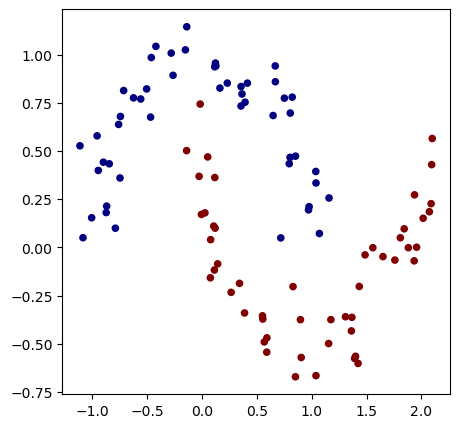

In [12]:
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)

# Y = Y*2-1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet')
plt.show()

# forward pass, backward pass, update - 2:

In [13]:
# X.shape # (100, 2)

Y

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [25]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
# print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [26]:
epochs = 150

losses = []

for epoch in range(0, epochs+1):

    # Step-1: forward pass:
    Yp = [model(x).sigmoid() for x in X]
    loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
    
    # Step-2: backward pass:
    for param in model.parameters():
        param.grad = 0.0
    #end-for
    loss.backward()


    # Step-3: update parameters:
    # step_size = 1.0 - ((0.9*epoch)/100.0)
    step_size = 0.01
    for param in model.parameters():
        param.data += - (step_size * param.grad)
    #end-for
        
    #outputs:
    print(f'epach:{epoch}, step_size={step_size}, loss:{loss.data:0.6f}')
    losses.append(loss.data)
#end-for

epach:0, step_size=0.01, loss:33.429021
epach:1, step_size=0.01, loss:21.241940
epach:2, step_size=0.01, loss:16.115835
epach:3, step_size=0.01, loss:15.762202
epach:4, step_size=0.01, loss:15.469830
epach:5, step_size=0.01, loss:15.227900
epach:6, step_size=0.01, loss:15.023747
epach:7, step_size=0.01, loss:14.847855
epach:8, step_size=0.01, loss:14.693751
epach:9, step_size=0.01, loss:14.556928
epach:10, step_size=0.01, loss:14.434103
epach:11, step_size=0.01, loss:14.322801
epach:12, step_size=0.01, loss:14.221112
epach:13, step_size=0.01, loss:14.127531
epach:14, step_size=0.01, loss:14.040856
epach:15, step_size=0.01, loss:13.960115
epach:16, step_size=0.01, loss:13.884518
epach:17, step_size=0.01, loss:13.813412
epach:18, step_size=0.01, loss:13.746259
epach:19, step_size=0.01, loss:13.682606
epach:20, step_size=0.01, loss:13.622070
epach:21, step_size=0.01, loss:13.564322
epach:22, step_size=0.01, loss:13.509081
epach:23, step_size=0.01, loss:13.456100
epach:24, step_size=0.01, 

In [27]:
losses[-1]

8.489296327324723

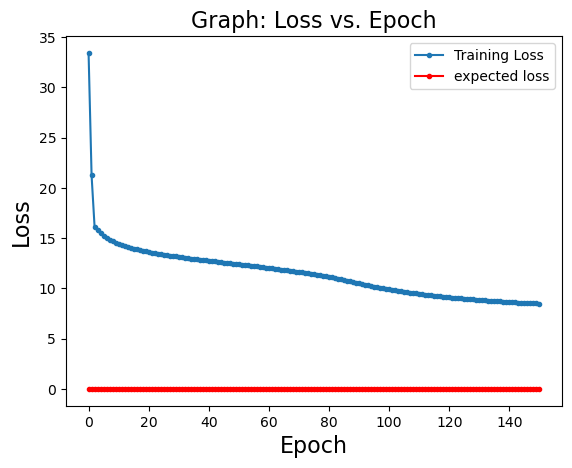

In [28]:
lossPlot(losses)

## prima diabetes:

In [28]:
import pandas as pd

# Load the dataset
df = pd.read_csv('diabetes.csv')

data = df.to_numpy() # Convert the dataset to a NumPy array

# Print the shape of the array
# print(data.shape)
# print(data)

X = data[:,:-1]
# print(X.shape)
Y = data[:,-1]
# print(Y)

In [48]:
model = MLP(8, [16, 16, 16, 1])
# print(model)
print("number of parameters", len(model.parameters()))

number of parameters 705


In [50]:
epochs = 10

losses = []

for epoch in range(0, epochs+1):

    # Step-1: forward pass:
    Yp = [model(x).sigmoid() for x in X]
    loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
    
    # Step-2: backward pass:
    for param in model.parameters():
        param.grad = 0.0
    #end-for
    loss.backward()


    # Step-3: update parameters:
    # step_size = 1.0 - ((0.9*epoch)/100.0)
    step_size = 0.01
    for param in model.parameters():
        param.data += - (step_size * param.grad)
    #end-for
        
    #outputs:
    print(f'epach:{epoch}, step_size={step_size}, loss:{loss.data:0.6f}')
    losses.append(loss.data)
#end-for

epach:0, step_size=0.01, loss:192.000000
epach:1, step_size=0.01, loss:192.000000
epach:2, step_size=0.01, loss:192.000000
epach:3, step_size=0.01, loss:192.000000
epach:4, step_size=0.01, loss:192.000000
epach:5, step_size=0.01, loss:192.000000
epach:6, step_size=0.01, loss:192.000000
epach:7, step_size=0.01, loss:192.000000
epach:8, step_size=0.01, loss:192.000000


In [38]:
Yp = [model(x) for x in X]

In [46]:
Yp = [yp.sigmoid() for yp in Yp]
print(Yp)

[Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.7308944777905114, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.7310585786300049, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=), Value(data=0.6224593312018546, grad=0.0, label=),

In [44]:
for yp in Yp:
    print(yp.sigmoid())
    break

Value(data=0.5, grad=0.0, label=)


# `step_size` or `learning_rate`:

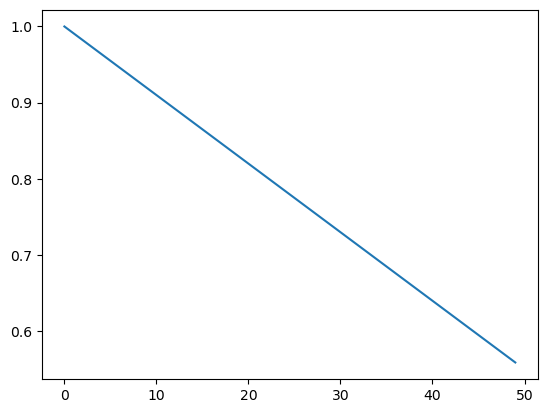

In [159]:
step_size = 1
epochs = 50
S = []
for epoch in range(epochs):
    step_size = 1. - (0.9*epoch)/100
    # print(step_size)
    S.append(step_size)
#end-for
    
plt.plot(S)
plt.show()

In [160]:
# epochs = 200

# step_size = 1.0
# for epoch in range(epochs):


#     # if step_size > 0.0:
#     #     pass
#     # else:
#     #     step_size = 0.001

#     print(step_size)
#     # step_size -= 0.009
# #end-for

In [161]:
N = 4 
V = np.random.randn(N) * np.sqrt(2.0/N)
print(V)
W = [Value(v) for v in V]
print(W)

[ 0.0528484  -0.32314751  0.42411402  1.40349462]
[Value(data=0.052848400454335955, grad=0.0, label=), Value(data=-0.3231475073976876, grad=0.0, label=), Value(data=0.4241140195838776, grad=0.0, label=), Value(data=1.4034946212844044, grad=0.0, label=)]


# GraphViz

In [162]:
# import graphviz  
dot = Digraph(comment='The Round Table')

dot.node('A', 'A')  
dot.node('B', 'B')
dot.edges(['AB', 'AC', 'AD', 'DB', 'BC'])
dot.node('C', 'C')
dot.node('D', 'D')

dot.edge('B', 'A', constraint='false')

In [163]:
# print(dot.source)

In [164]:
dot.render('round-table', view=True)  
# doctest_mark_exe()


'round-table.pdf'

In [165]:
for i in range(10):
    print(i)
#end-forL

0
1
2
3
4
5
6
7
8
9


dd

### learning rate decay:

In [166]:
# epochs = 500

# for epoch in range(epochs):
#     lr = 1- ((0.9*epoch)/100.0)
#     print(lr)
# #end-for

# Square Numbers:

In [230]:
h = 0.5

X = list(np.arange(-20, 20+h, h))
Y = [x*x for x in X]

X = np.array(X).reshape(-1, 1)


network = MLP(1, [2, 1])

In [231]:
len(Y)

81

In [232]:
network([12])

Value(data=0.0, grad=0.0, label=)

In [233]:
maxIter = 100
step_size = 0.01
threshold = 0.1

params = network.parameters()

losses = []

for epoch in range(maxIter):
    # Forward pass
    Yp = [network(x) for x in X]
    loss = sum((y-yp)**2 for (y,yp) in zip(Y, Yp))

    # Backward pass
    for param in params:
        param.grad = 0.0
    #end-for
    loss.backward()


    # Update
    for param in params:
        param.data += -(step_size * param.grad)
    #end-def
        
    #outputs:
    print(f'epach:{epoch}, step_size={step_size}, loss:{loss.data:0.6f}')
    losses.append(loss.data)
#end-for

epach:0, step_size=0.01, loss:2722666.500000
epach:1, step_size=0.01, loss:2722666.500000
epach:2, step_size=0.01, loss:2722666.500000
epach:3, step_size=0.01, loss:2722666.500000
epach:4, step_size=0.01, loss:2722666.500000
epach:5, step_size=0.01, loss:2722666.500000
epach:6, step_size=0.01, loss:2722666.500000
epach:7, step_size=0.01, loss:2722666.500000
epach:8, step_size=0.01, loss:2722666.500000
epach:9, step_size=0.01, loss:2722666.500000
epach:10, step_size=0.01, loss:2722666.500000
epach:11, step_size=0.01, loss:2722666.500000
epach:12, step_size=0.01, loss:2722666.500000
epach:13, step_size=0.01, loss:2722666.500000
epach:14, step_size=0.01, loss:2722666.500000
epach:15, step_size=0.01, loss:2722666.500000
epach:16, step_size=0.01, loss:2722666.500000
epach:17, step_size=0.01, loss:2722666.500000
epach:18, step_size=0.01, loss:2722666.500000
epach:19, step_size=0.01, loss:2722666.500000
epach:20, step_size=0.01, loss:2722666.500000
epach:21, step_size=0.01, loss:2722666.50000

In [238]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.linear = nn.Linear(1, 1)
    #end-def
        
    def forward(self, x):
        return self.linear(x)
    #end-def
#end-class

# Create an instance of the model
model = NN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [243]:
# h = 0.5

# X = list(np.arange(-20, 20+h, h))
# # Y = [x*x for x in X]
# X = torch.tensor(X, dtype=torch.float32).reshape(-1,1)

# Y = X**2.0
# print(X)

In [255]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
class SquarePredictor(nn.Module):
    def __init__(self):
        super(SquarePredictor, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Create an instance of the model
model = SquarePredictor()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
# input_values = torch.tensor([[2.0], [3.0], [4.0], [5.0]], dtype=torch.float32)
# target_values = torch.tensor([[4.0], [9.0], [16.0], [25.0]], dtype=torch.float32)


input_values = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.float32).reshape(-1,1)

target_values = torch.tensor([1, 4, 9, 16, 25, 36, 49, 64, 81, 100], dtype=torch.float32).reshape(-1,1)


# Training loop
epochs = 5000
for epoch in range(epochs):
    # Forward pass
    predictions = model(input_values)
    loss = criterion(predictions, target_values)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Test the model
test_value = torch.tensor([[6.0]], dtype=torch.float32)
predicted_square = model(test_value).item()

print(f'Predicted square of {test_value.item()}: {predicted_square}')


Epoch 0/5000, Loss: 3115.481201171875
Epoch 100/5000, Loss: 104.68913269042969
Epoch 200/5000, Loss: 75.16357421875
Epoch 300/5000, Loss: 62.43841552734375
Epoch 400/5000, Loss: 56.954017639160156
Epoch 500/5000, Loss: 54.59032440185547
Epoch 600/5000, Loss: 53.57158660888672
Epoch 700/5000, Loss: 53.13254928588867
Epoch 800/5000, Loss: 52.94330978393555
Epoch 900/5000, Loss: 52.861778259277344
Epoch 1000/5000, Loss: 52.826622009277344
Epoch 1100/5000, Loss: 52.81145095825195
Epoch 1200/5000, Loss: 52.804954528808594
Epoch 1300/5000, Loss: 52.8021240234375
Epoch 1400/5000, Loss: 52.8009147644043
Epoch 1500/5000, Loss: 52.800384521484375
Epoch 1600/5000, Loss: 52.80015182495117
Epoch 1700/5000, Loss: 52.800086975097656
Epoch 1800/5000, Loss: 52.800018310546875
Epoch 1900/5000, Loss: 52.800010681152344
Epoch 2000/5000, Loss: 52.800018310546875
Epoch 2100/5000, Loss: 52.800010681152344
Epoch 2200/5000, Loss: 52.800018310546875
Epoch 2300/5000, Loss: 52.79998779296875
Epoch 2400/5000, Loss